In [1]:
import pandas

In [2]:
features = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash",
    "Magnesium", "Total phenols", "Flavanoids", "Nonflavanoid phenols",
    "Proanthocyanins", "Color intensity", "Hue",
    "OD280/OD315 of diluted wines", "Proline"]
target = 'Class'

# Load a Data Set

This is a rather simple dataset. It is easy to get a good performance with even very simple classifiers.

In [3]:
df = pandas.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', names=[target] + features)

In [4]:
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Alcohol Content per Class')

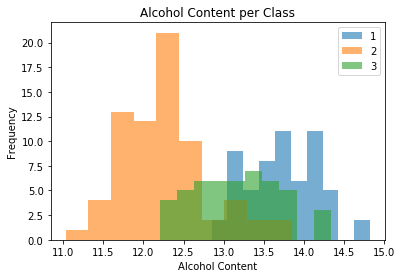

In [6]:
for c, d in df.groupby('Class'):
    d.Alcohol.plot.hist(label=c, alpha=0.6)
plt.legend()
plt.xlabel('Alcohol Content')
plt.title('Alcohol Content per Class')

# Find Feature Importance by Achieved Accuracy Score

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [11]:
train_data, test_data = train_test_split(df, test_size=0.2)

Note that we can specify values for a complete set $\{ f(x) \mid x \in X\}$ with the syntax  `[f[i] for x in X]` as shown below.

In [12]:
models = [KNeighborsClassifier(n_neighbors=5).fit(train_data[[f]], train_data[target]) for f in features]

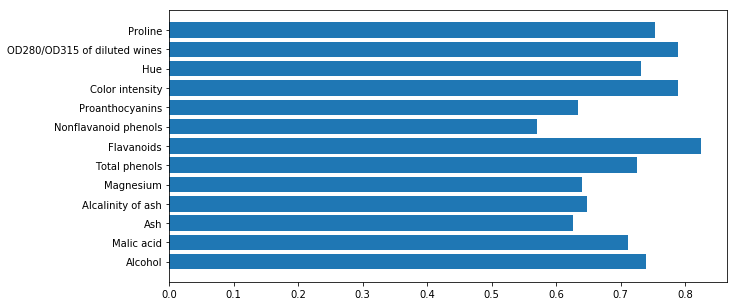

In [13]:
train_scores = [accuracy_score(train_data[target], m.predict(train_data[[f]])) for m, f in zip(models, features)]
plt.barh(range(len(features)), train_scores)
plt.yticks(range(len(features)), features)
plt.gcf().set_size_inches(10, 5)
None

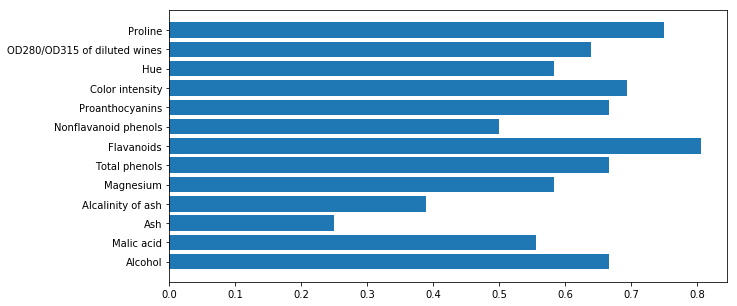

In [14]:
scores = [accuracy_score(test_data[target], m.predict(test_data[[f]])) for m, f in zip(models, features)]
plt.barh(range(len(features)), scores)
plt.yticks(range(len(features)), features)
plt.gcf().set_size_inches(10, 5)

# Which k Should You Choose?

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
df_scaled = pandas.DataFrame(StandardScaler().fit_transform(df[features]), columns=features)
df_scaled[target] = df[target]

In [17]:
train_data_s, test_data_s = train_test_split(df_scaled, test_size=0.2)

In [18]:
N, _ = train_data_s.shape
N_test, _ = test_data_s.shape

In [19]:
ks = range(1, 100)
models = [KNeighborsClassifier(n_neighbors=k).fit(train_data_s[features], train_data_s[target]) for k in ks]
train_scores = [accuracy_score(train_data_s[target], m.predict(train_data_s[features])) for m in models]
test_scores = [accuracy_score(test_data_s[target], m.predict(test_data_s[features])) for m in models]

## Test score performance

Were we omniscient, we could just look at the test scores. These the performance of model $\lambda(k, D_T)$ on $D^*$. From the plot below we can see that almost any value below 90 or so works pretty well. We also see a discrepancy between the maximising values in the training and test set. The best value for the training set is simply $k = 1$. However good test set values occur starting from $k=3$.

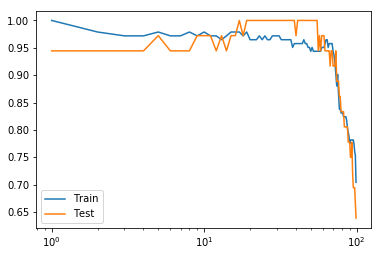

In [20]:
plt.semilogx(ks, train_scores, ks, test_scores);
plt.legend(["Train", "Test"])

## Cross validation to choose $k$


In [49]:
from sklearn.model_selection import cross_val_score

In [50]:
neighbor_ks = range(1, 100)
untrained_models = [KNeighborsClassifier(n_neighbors=k) for k in neighbor_ks]

In [51]:
k_fold_scores = [cross_val_score(estimator=m, X=df_scaled[features], y=df_scaled[target], cv=10) for m in untrained_models]

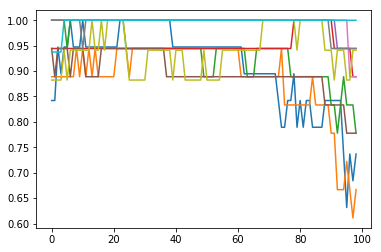

In [52]:
plt.plot(k_fold_scores)

None

<ErrorbarContainer object of 3 artists>

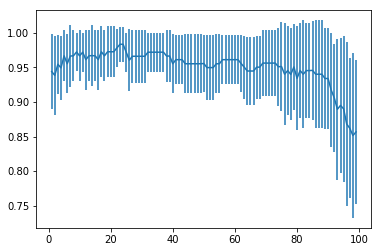

In [53]:
mean_xv_scores = [s.mean() for s in k_fold_scores] 
plt.errorbar(neighbor_ks, mean_xv_scores, yerr=[s.std() for s in k_fold_scores])


23 1 1


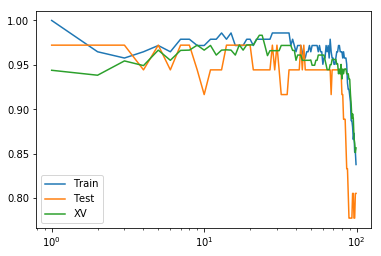

In [54]:
# now let us compare the best values for training test and cross validation

import numpy
knn_best_k_xv = numpy.asarray(mean_xv_scores).argmax()
knn_best_k_train = numpy.asarray(train_scores).argmax()
knn_best_k_test = numpy.asarray(test_scores).argmax()
print(ks[knn_best_k_xv], ks[knn_best_k_train], ks[knn_best_k_test])
plt.semilogx(ks, train_scores, ks, test_scores, ks, mean_xv_scores)
plt.legend(["Train", "Test", "XV"])

# Let's select the best model on the basis of the XV score, as we must, since the 'test' result is invisible to us
knn_best_model_xv = models[knn_best_k_xv]

# Bootstrapping

Bootsrapping is useful for two things. First, remember that even though the test score is an /independent/ measurement of an algorithm's performance, it is /not/ the actual expected performance. At best, it's an unbiased estimate of performance. Hence, we'd like to have some way to calculate a likely performance range from the test data. Bootstrapping can help: by taking multiple samples of the test set and calculating performance on each one, we obtain an empirical distribution of scores.

Secondly, we can use it to tell us something about the sensitivity of our algorithm. In particular, by taking multiple samples from the training data, we can end up with multiple models. If the models are only slightly different, then the algorithm is more stable and we can be more confident in its predictions. This also allows us to generate probabilistic predictions from deterministic classification algorithms, by simply averaging predictions from multiple bootstrapped predictors.

In [162]:
import sklearn.utils # we can use sklearn.utils.resample to bootstrap
n_bootstrap_samples = 1000 # the more samples we take the better our distributional estimates

Text(0.5,1,'Bootstrapped test scores for best kNN model')

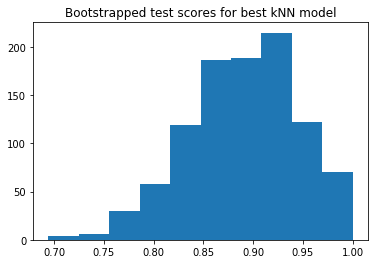

In [163]:
# Now we are going to estimate how sensitive is the test result to the test data
bootstrap_test_score = numpy.zeros(n_bootstrap_samples)

# For each bootstrap sample, we get a different model. There is no need to save the model, as we just want the score on the test set.
for t in range(n_bootstrap_samples):
    bootstrap_test_sample = sklearn.utils.resample(test_data_s, replace=True, n_samples = N_test)
    bootstrap_test_score[t] = accuracy_score(bootstrap_test_sample[target], knn_best_model_xv.predict(bootstrap_test_sample[features]))

plt.hist(bootstrap_test_score)
plt.title("Bootstrapped test scores for best kNN model")

(array([  1.,   4.,  23.,  85., 200., 229., 191., 163., 101.,   3.]),
 array([0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875, 0.9  , 0.925, 0.95 ,
        0.975, 1.   ]),
 <a list of 10 Patch objects>)

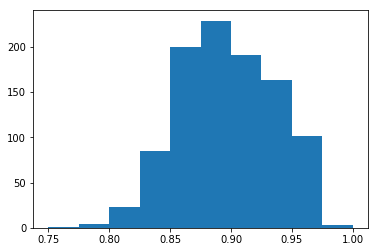

In [164]:
# Now we are going to estimate the sensitivity of the algorithm to the training data
bootstrap_score = numpy.zeros(n_bootstrap_samples)

# For each bootstrap sample, we get a different model. There is no need to save the model, as we just want the score on the test set.
for t in range(n_bootstrap_samples):
    bootstrap_sample = sklearn.utils.resample(train_data_s, replace=True, n_samples = N)
    bootstrap_model = KNeighborsClassifier(n_neighbors=knn_best_k_xv).fit(bootstrap_sample[features], bootstrap_sample[target])
    bootstrap_score[t] = accuracy_score(test_data_s[target], bootstrap_model.predict(test_data_s[features]))
plt.hist(bootstrap_score)

In [150]:
bootstrap_score.sort()

In [76]:
bootstrap_score

array([0.86111111, 0.86111111, 0.86111111, 0.86111111, 0.86111111,
       0.86111111, 0.86111111, 0.86111111, 0.86111111, 0.86111111,
       0.86111111, 0.86111111, 0.86111111, 0.86111111, 0.86111111,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888889,
       0.88888889, 0.88888889, 0.88888889, 0.88888889, 0.88888